In [1]:
!pip uninstall -y tensorflow keras  # Uninstall existing TensorFlow and Keras versions
!pip uninstall -y tensorflow-decision-forests tensorflow-text tf-keras
!pip install tensorflow==2.8.0 keras==2.8.0  # Install TensorFlow 2.8.0 and Keras 2.8.0

Found existing installation: tensorflow 2.17.0
Uninstalling tensorflow-2.17.0:
  Successfully uninstalled tensorflow-2.17.0
Found existing installation: keras 3.4.1
Uninstalling keras-3.4.1:
  Successfully uninstalled keras-3.4.1
Found existing installation: tensorflow_decision_forests 1.10.0
Uninstalling tensorflow_decision_forests-1.10.0:
  Successfully uninstalled tensorflow_decision_forests-1.10.0
Found existing installation: tensorflow-text 2.17.0
Uninstalling tensorflow-text-2.17.0:
  Successfully uninstalled tensorflow-text-2.17.0
Found existing installation: tf_keras 2.17.0
Uninstalling tf_keras-2.17.0:
  Successfully uninstalled tf_keras-2.17.0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 497.6/497.6 MB 3.4 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 37.5 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 462.5/462.5 kB 25.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 2.6 MB/s eta 0:00:00
   ━

In [2]:
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Activation, BatchNormalization, Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.callbacks import ReduceLROnPlateau,EarlyStopping, ModelCheckpoint
# from keras.utils.vis_utils import model_to_dot
from tensorflow.keras.utils import model_to_dot
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score
from IPython.display import Image

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pathlib
import shutil
import seaborn as sns
import os
import zipfile

In [3]:
import tensorflow as tf
print(tf.__version__)  # Should print 2.8.0

2.8.0


In [4]:
!conda install -y gdown

/bin/bash: line 1: conda: command not found


/usr/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [5]:
!gdown 1m73xAQM7pVlEt1PQK30r8Yx6T1llHFyO

Downloading...
From (original): https://drive.google.com/uc?id=1m73xAQM7pVlEt1PQK30r8Yx6T1llHFyO
From (redirected): https://drive.google.com/uc?id=1m73xAQM7pVlEt1PQK30r8Yx6T1llHFyO&confirm=t&uuid=fe67f669-36fa-4845-a70e-e9b58f0e6b22
To: /kaggle/working/FerPlus.zip
100%|███████████████████████████████████████| 69.3M/69.3M [00:00<00:00, 197MB/s]


In [6]:
z= zipfile.ZipFile('FerPlus.zip')
z.extractall()
!rm -rf FerPlus.zip
!rm -rf .virtual_documents

In [7]:
train_data_dir = pathlib.Path("/kaggle/working")
HEIGHT = 48
WIDTH = 48
batch_size = 128

In [8]:
def image_gen():
    train_datagen = ImageDataGenerator(rescale=1./255,
          shear_range = 0.2,
          zoom_range = 0.2,
          horizontal_flip = True,
          validation_split = 0.2) # set validation split
    
    train_generator = train_datagen.flow_from_directory(
      train_data_dir,
      target_size = (HEIGHT, WIDTH),
      batch_size = batch_size,
      color_mode = "grayscale",
      class_mode ='categorical',
      subset ='training') # set as training data

    validation_generator = train_datagen.flow_from_directory(
      train_data_dir, # same directory as training data
      target_size = (HEIGHT, WIDTH),
      batch_size = batch_size,
      color_mode = "grayscale",
      class_mode = 'categorical',
      subset = 'validation') # set as validation data
    
    return train_generator, validation_generator

train_generator, validation_generator = image_gen()

Found 29762 images belonging to 8 classes.
Found 7438 images belonging to 8 classes.


In [9]:
def counts(gen):
    index = 0
    labels = {"Angry": 0, "Contempt": 0, "Disgust": 0, "Fear": 0, "Happy": 0, "Neutral": 0, "Sad": 0, "Surprise": 0}
    count = np.array([0]* len(labels))
    for i in range(len(gen)):
        batch = next(gen)
        a, b = np.unique(np.argmax(batch[1], axis=1)-1, return_counts=True)
        #print("Batch labels:", np.unique(np.argmax(batch[1], axis=1)))
        count[a] += b
    for l in labels:
        labels[l] = count[index]
        index += 1
    
    plt.bar(labels.keys(), labels.values(), width = 1.0)
    plt.show()
    
    return labels

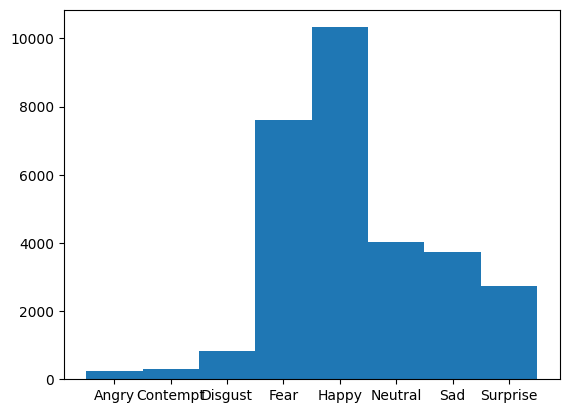

{'Angry': 245,
 'Contempt': 288,
 'Disgust': 841,
 'Fear': 7603,
 'Happy': 10324,
 'Neutral': 4012,
 'Sad': 3722,
 'Surprise': 2727}

In [10]:
train_count = counts(train_generator)
train_count

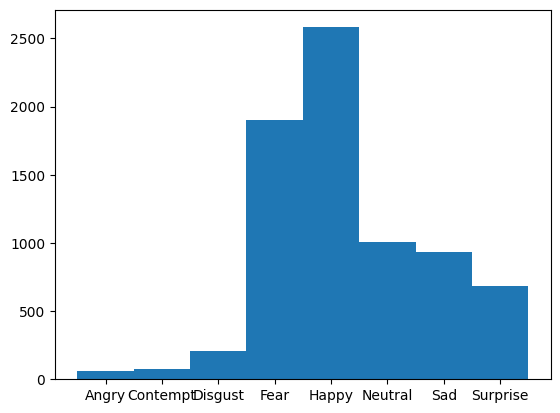

{'Angry': 61,
 'Contempt': 72,
 'Disgust': 210,
 'Fear': 1900,
 'Happy': 2581,
 'Neutral': 1003,
 'Sad': 930,
 'Surprise': 681}

In [11]:
validation_count = counts(validation_generator)
validation_count

In [12]:
train_generator, validation_generator = image_gen()
num_train = 29762
num_val = 7438
num_epoch = 40

Found 29762 images belonging to 8 classes.
Found 7438 images belonging to 8 classes.


In [13]:
def C_Model():
    model = Sequential()

    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(48,48,1)))
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(8, activation='softmax'))
    
    return model

Classify = C_Model()

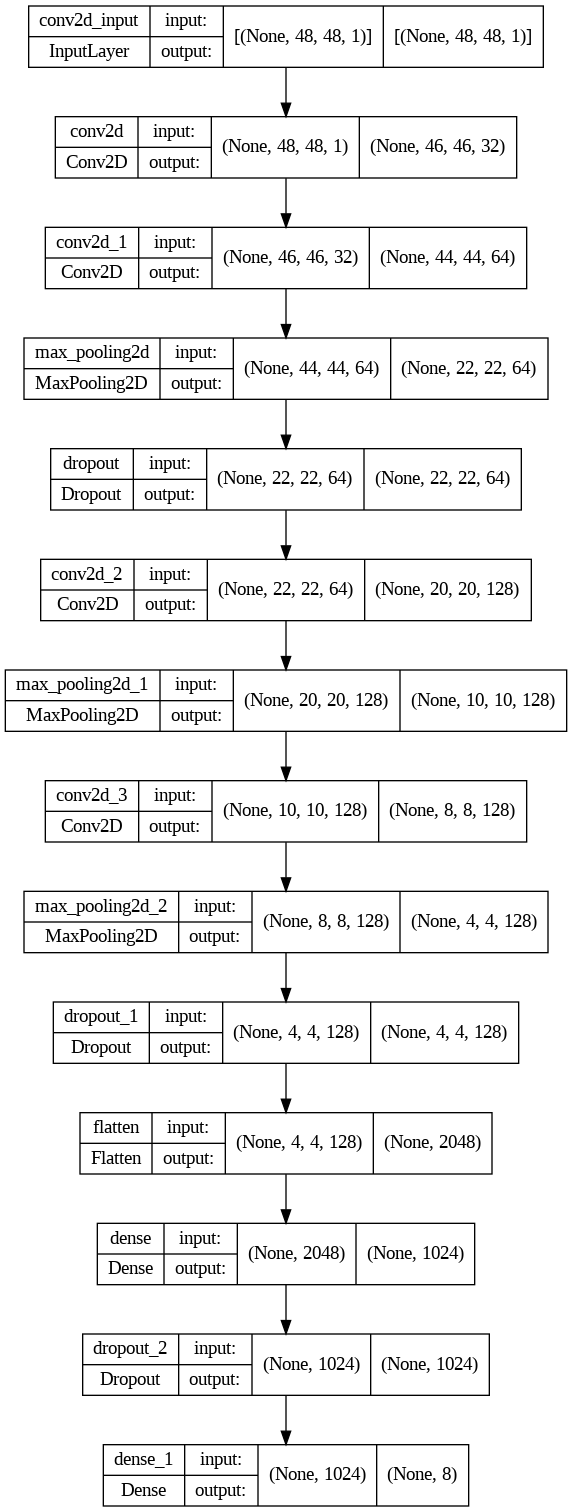

In [14]:
Image(model_to_dot(Classify, show_shapes=True).create_png())

In [15]:
# Print all class names in the train generator
print("Class names in train_generator:")
for class_name, index in train_generator.class_indices.items():
    print(f"Class {index}: {class_name}")

Class names in train_generator:
Class 0: Anger
Class 1: Contempt
Class 2: Disgust
Class 3: Fear
Class 4: Happiness
Class 5: Neutral
Class 6: Sadness
Class 7: Surprise


In [16]:
def compile(model):
    # # Define the initial learning rate and decay rate
    # initial_learning_rate = 0.001  # Same as before
    # decay_rate = 1e-6
    # steps_per_epoch = num_train // batch_size  # Total steps in one epoch
    # decay_steps = steps_per_epoch * num_epoch  # Total training steps

    # # Define the learning rate schedule
    # lr_schedule = ExponentialDecay(
    #     initial_learning_rate=initial_learning_rate,
    #     decay_steps=decay_steps,
    #     decay_rate=1 - decay_rate,  # Adjusting the decay rate
    #     staircase=False  # Smooth decay
    # )

    # model.compile(loss = 'categorical_crossentropy', optimizer = Adam(learning_rate=lr_schedule), metrics=['accuracy'])
    model.compile(loss = 'categorical_crossentropy', optimizer = Adam(learning_rate = 0.001, decay=1e-6), metrics=['accuracy'])
    history = model.fit(
        train_generator,
        steps_per_epoch = num_train // batch_size,
        epochs = num_epoch,
        validation_data=validation_generator,
        validation_steps = num_val // batch_size)
    model.save_weights('model.weights.h5')
    
    return history

history = compile(Classify)

Epoch 1/40
232/232 [==============================] - 176s 756ms/step - loss: 1.6304 - accuracy: 0.3580 - val_loss: 1.4846 - val_accuracy: 0.4452
Epoch 2/40
232/232 [==============================] - 175s 756ms/step - loss: 1.3839 - accuracy: 0.5001 - val_loss: 1.2352 - val_accuracy: 0.5610
Epoch 3/40
232/232 [==============================] - 172s 743ms/step - loss: 1.1825 - accuracy: 0.5816 - val_loss: 1.0615 - val_accuracy: 0.6202
Epoch 4/40
232/232 [==============================] - 173s 744ms/step - loss: 1.0733 - accuracy: 0.6147 - val_loss: 0.9966 - val_accuracy: 0.6447
Epoch 5/40
232/232 [==============================] - 175s 754ms/step - loss: 1.0012 - accuracy: 0.6429 - val_loss: 0.9335 - val_accuracy: 0.6592
Epoch 6/40
232/232 [==============================] - 175s 755ms/step - loss: 0.9507 - accuracy: 0.6599 - val_loss: 0.9013 - val_accuracy: 0.6743
Epoch 7/40
232/232 [==============================] - 173s 748ms/step - loss: 0.9166 - accuracy: 0.6745 - val_loss: 0.8590 -

In [23]:
def save_model(model, model_name):
    model.save(model_name)

save_model(Classify, "Model_1.h5")

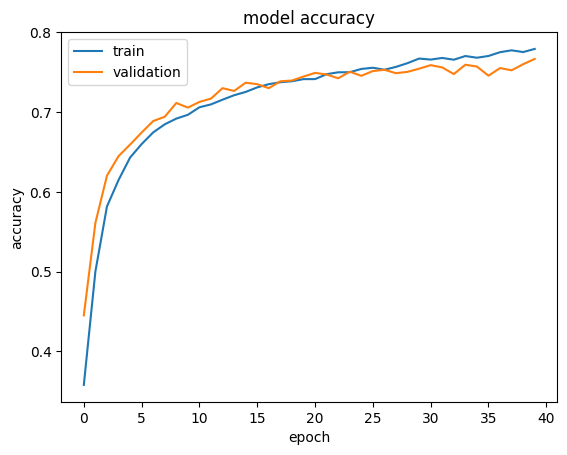

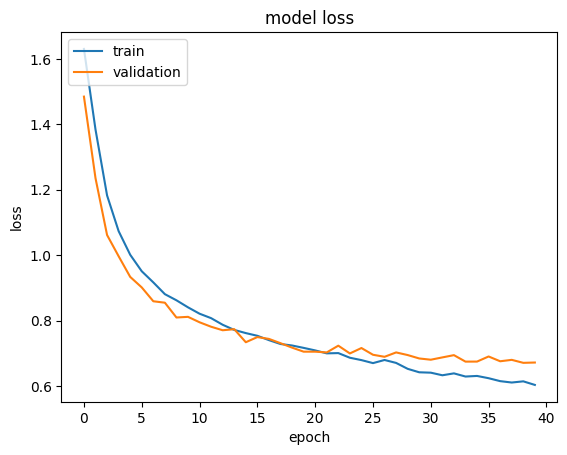

In [24]:
def plot_history(history):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

plot_history(history)

In [19]:
# idx_to_emotion_fer = {0:"Disgust", 1:"Anger", 2:"Disgust", 3:"Fear", 4:"Happiness", 5:"Neutral", 6:"Sadness", 7:"Surprise"}

In [20]:
# def return_data(validation_generator):    
#     batch_index = 0
#     data = validation_generator[0]

#     while batch_index <= len(validation_generator):
#         if batch_index == 0:
#             X_test = np.array(data[0])
#             Y_test = np.array(data[1])
#         else:   
#             data = validation_generator.next()
#             X_test = np.append(X_test, data[0], axis=0)
#             Y_test = np.append(Y_test, data[1], axis=0)
#         batch_index = batch_index + 1
#     return X_test, Y_test

# X_test, Y_test = return_data(validation_generator)

In [21]:
# def evaluate(model, X_test, Y_test):
# #     model.load_weights(weights_path)
# #     y_pred = model.predict_generator(test_flow, steps=X_test.shape[0])
# #     y_pred_cat = np.argmax(y_pred, axis=1)
# #     y_true_cat = np.argmax(test_flow.y, axis=1)
    
#     y_predict = model.predict(X_test)
#     y_pred_cat = np.argmax(y_predict, axis=1)
#     y_true_cat = np.argmax(Y_test, axis=1)
#     report = classification_report(y_true_cat, y_pred_cat)
#     print(report)

#     conf = confusion_matrix(y_true_cat, y_pred_cat, normalize="true")

#     labels = idx_to_emotion_fer.values()
#     _, ax = plt.subplots(figsize=(8, 6))
#     ax = sns.heatmap(conf, annot=True, cmap='YlGnBu', 
#                      xticklabels=labels, 
#                      yticklabels=labels)

#     plt.show()

In [22]:
# evaluate(Classify, X_test, Y_test)